# Задача
Классификация датасета cifar10 на хорошие показатели максимально небольшой моделью (быстрое и оптимальне решение)

## Подготовка данных

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # means and standard deviations for each color channel (of our dataset!) (RGB) in the image. From Cifar10 analisis article
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), # crop, flip and add padings to create more data from our datasen and create something like dropout on data level
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
#donloading data
train_dataset = torchvision.datasets.CIFAR10(root='./dataset1/',
                                             train=True,
                                             transform=train_tfms,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./dataset1/',
                                            train=False,
                                            transform=valid_tfms)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
# Creating data loaders
batch_size = 400
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(test_dataset, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#moving data to gpu (or cpu), standart move .to(device) works slower and often throws errors in my case
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
#check device
device = get_default_device()
device

device(type='cuda')

In [ ]:
# moving datasets
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Модель

In [ ]:
def accuracy(outputs, labels): # create accuracy metric
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):   # base (img) classification block
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False): #convolutional block
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase): # actual ResNet model classification + conv blocks
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 10), device) # 3 - RGB, 10 - classes
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Тренировка и тестирование модели

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,       #trainer
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in tqdm(range(epochs)):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [] # training statistic saves here
# training parametrs
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, #train model
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00151, train_loss: 0.1257, val_loss: 0.3196, val_acc: 0.8998
Epoch [1], last_lr: 0.00435, train_loss: 0.2212, val_loss: 0.4848, val_acc: 0.8388
Epoch [2], last_lr: 0.00759, train_loss: 0.3699, val_loss: 0.6219, val_acc: 0.8095
Epoch [3], last_lr: 0.00971, train_loss: 0.4212, val_loss: 0.6819, val_acc: 0.7832
Epoch [4], last_lr: 0.00994, train_loss: 0.4019, val_loss: 0.6872, val_acc: 0.7741
Epoch [5], last_lr: 0.00950, train_loss: 0.3977, val_loss: 0.5227, val_acc: 0.8265
Epoch [6], last_lr: 0.00867, train_loss: 0.3725, val_loss: 0.6943, val_acc: 0.7725
Epoch [7], last_lr: 0.00750, train_loss: 0.3417, val_loss: 0.4171, val_acc: 0.8655
Epoch [8], last_lr: 0.00611, train_loss: 0.3231, val_loss: 0.4320, val_acc: 0.8563
Epoch [9], last_lr: 0.00463, train_loss: 0.2785, val_loss: 0.3483, val_acc: 0.8820
Epoch [10], last_lr: 0.00317, train_loss: 0.2349, val_loss: 0.3072, val_acc: 0.8975
Epoch [11], last_lr: 0.00188, train_loss: 0.1887, val_loss: 0.2997, val_acc: 0.9004
Ep

## Метрики модели

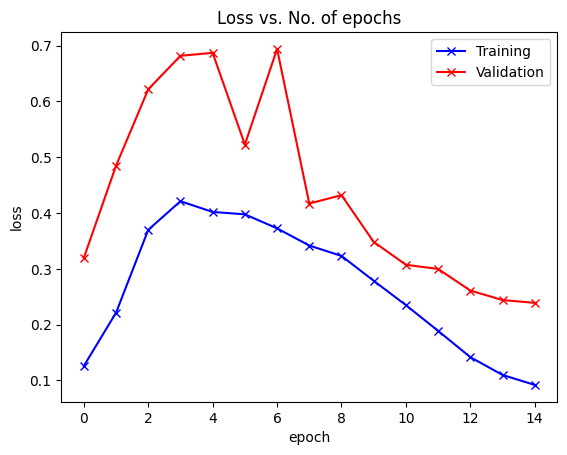

In [ ]:
#@title plot
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_losses(history)

## Сохранение и загрука модели

In [ ]:
torch.save(model.state_dict(), 'cifar10-resnet.pth')

In [ ]:
model = torch.load('./cifar10-resnet.pth')